number of parameters: 4732161
self.subjects ['sub-01']
exclude_subject None


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Data tensor shape: torch.Size([200, 63, 250]), label tensor shape: torch.Size([200]), text length: 200, image length: 2000


Epoch 1/1 - Test Loss: 10.3791, Test Accuracy: 0.2200, Top5 Accuracy: 0.5400
Epoch 1/1 - v2 Accuracy:0.96 - v4 Accuracy:0.89 - v10 Accuracy:0.755


Results saved to ./generation_metric_outputs/NICE_sub-01.csv
self.subjects ['sub-02']
exclude_subject None
Data tensor shape: torch.Size([200, 63, 250]), label tensor shape: torch.Size([200]), text length: 200, image length: 200


Epoch 1/1 - Test Loss: 10.4730, Test Accuracy: 0.1600, Top5 Accuracy: 0.4150
Epoch 1/1 - v2 Accuracy:0.92 - v4 Accuracy:0.815 - v10 Accuracy:0.6


Results saved to ./generation_metric_outputs/NICE_sub-02.csv
self.subjects ['sub-03']
exclude_subject None
Data tensor shape: torch.Size([200, 63, 250]), label tensor shape: torch.Size([200]), text length: 200, image length: 200


Epoch 1/1 - Test Loss: 10.5701, Test Accuracy: 0.2250, Top5 Accuracy: 0.5950
Epoch 1/1 - v2 Accuracy:0.955 - v4 Accuracy:0.92 - v10 Accuracy:0.76


Results saved to ./generation_metric_outputs/NICE_sub-03.csv
self.subjects ['sub-04']
exclude_subject None
Data tensor shape: torch.Size([200, 63, 250]), label tensor shape: torch.Size([200]), text length: 200, image length: 200


Epoch 1/1 - Test Loss: 10.5447, Test Accuracy: 0.2250, Top5 Accuracy: 0.5600
Epoch 1/1 - v2 Accuracy:0.94 - v4 Accuracy:0.855 - v10 Accuracy:0.69


Results saved to ./generation_metric_outputs/NICE_sub-04.csv
self.subjects ['sub-05']
exclude_subject None
Data tensor shape: torch.Size([200, 63, 250]), label tensor shape: torch.Size([200]), text length: 200, image length: 200


Epoch 1/1 - Test Loss: 10.5109, Test Accuracy: 0.0800, Top5 Accuracy: 0.3000
Epoch 1/1 - v2 Accuracy:0.885 - v4 Accuracy:0.755 - v10 Accuracy:0.57


Results saved to ./generation_metric_outputs/NICE_sub-05.csv
self.subjects ['sub-06']
exclude_subject None
Data tensor shape: torch.Size([200, 63, 250]), label tensor shape: torch.Size([200]), text length: 200, image length: 200


Epoch 1/1 - Test Loss: 10.2762, Test Accuracy: 0.1450, Top5 Accuracy: 0.4100
Epoch 1/1 - v2 Accuracy:0.935 - v4 Accuracy:0.795 - v10 Accuracy:0.615


Results saved to ./generation_metric_outputs/NICE_sub-06.csv
self.subjects ['sub-07']
exclude_subject None
Data tensor shape: torch.Size([200, 63, 250]), label tensor shape: torch.Size([200]), text length: 200, image length: 200


Epoch 1/1 - Test Loss: 9.9097, Test Accuracy: 0.2050, Top5 Accuracy: 0.4750
Epoch 1/1 - v2 Accuracy:0.98 - v4 Accuracy:0.86 - v10 Accuracy:0.68


Results saved to ./generation_metric_outputs/NICE_sub-07.csv
self.subjects ['sub-08']
exclude_subject None
Data tensor shape: torch.Size([200, 63, 250]), label tensor shape: torch.Size([200]), text length: 200, image length: 200


Epoch 1/1 - Test Loss: 9.6418, Test Accuracy: 0.3600, Top5 Accuracy: 0.7050
Epoch 1/1 - v2 Accuracy:0.985 - v4 Accuracy:0.925 - v10 Accuracy:0.835


Results saved to ./generation_metric_outputs/NICE_sub-08.csv
self.subjects ['sub-09']
exclude_subject None
Data tensor shape: torch.Size([200, 63, 250]), label tensor shape: torch.Size([200]), text length: 200, image length: 200


Epoch 1/1 - Test Loss: 9.1586, Test Accuracy: 0.2050, Top5 Accuracy: 0.4050
Epoch 1/1 - v2 Accuracy:0.95 - v4 Accuracy:0.78 - v10 Accuracy:0.665


Results saved to ./generation_metric_outputs/NICE_sub-09.csv
self.subjects ['sub-10']
exclude_subject None
Data tensor shape: torch.Size([200, 63, 250]), label tensor shape: torch.Size([200]), text length: 200, image length: 200


Epoch 1/1 - Test Loss: 8.9136, Test Accuracy: 0.2500, Top5 Accuracy: 0.5650
Epoch 1/1 - v2 Accuracy:0.96 - v4 Accuracy:0.87 - v10 Accuracy:0.68


Results saved to ./generation_metric_outputs/NICE_sub-10.csv


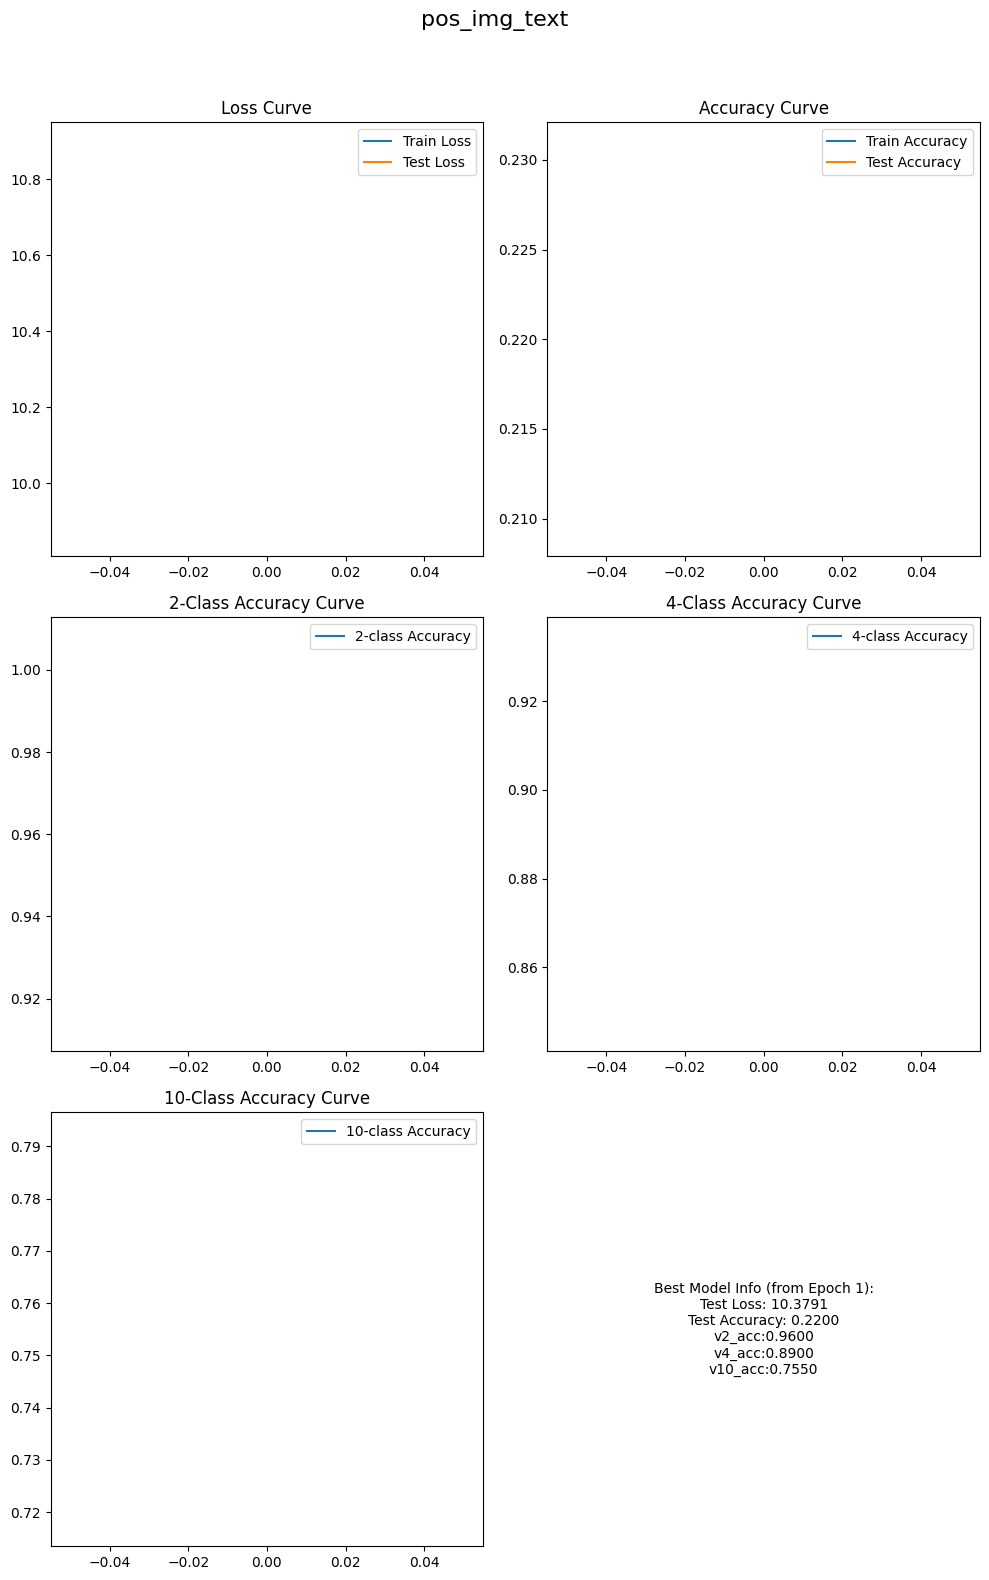

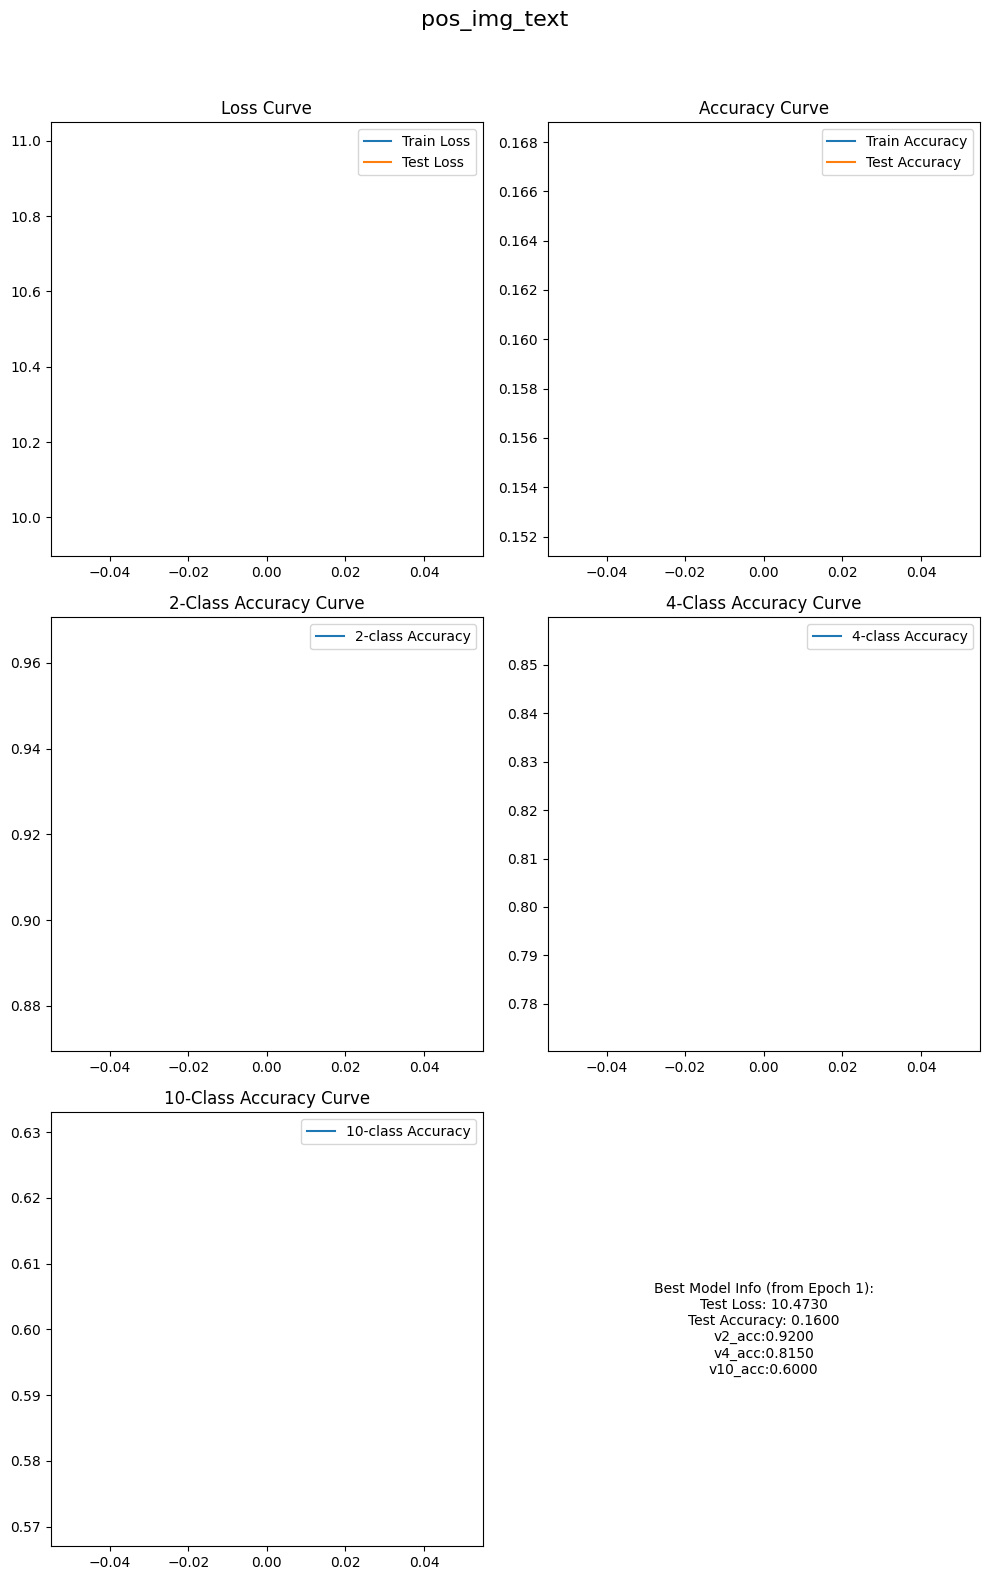

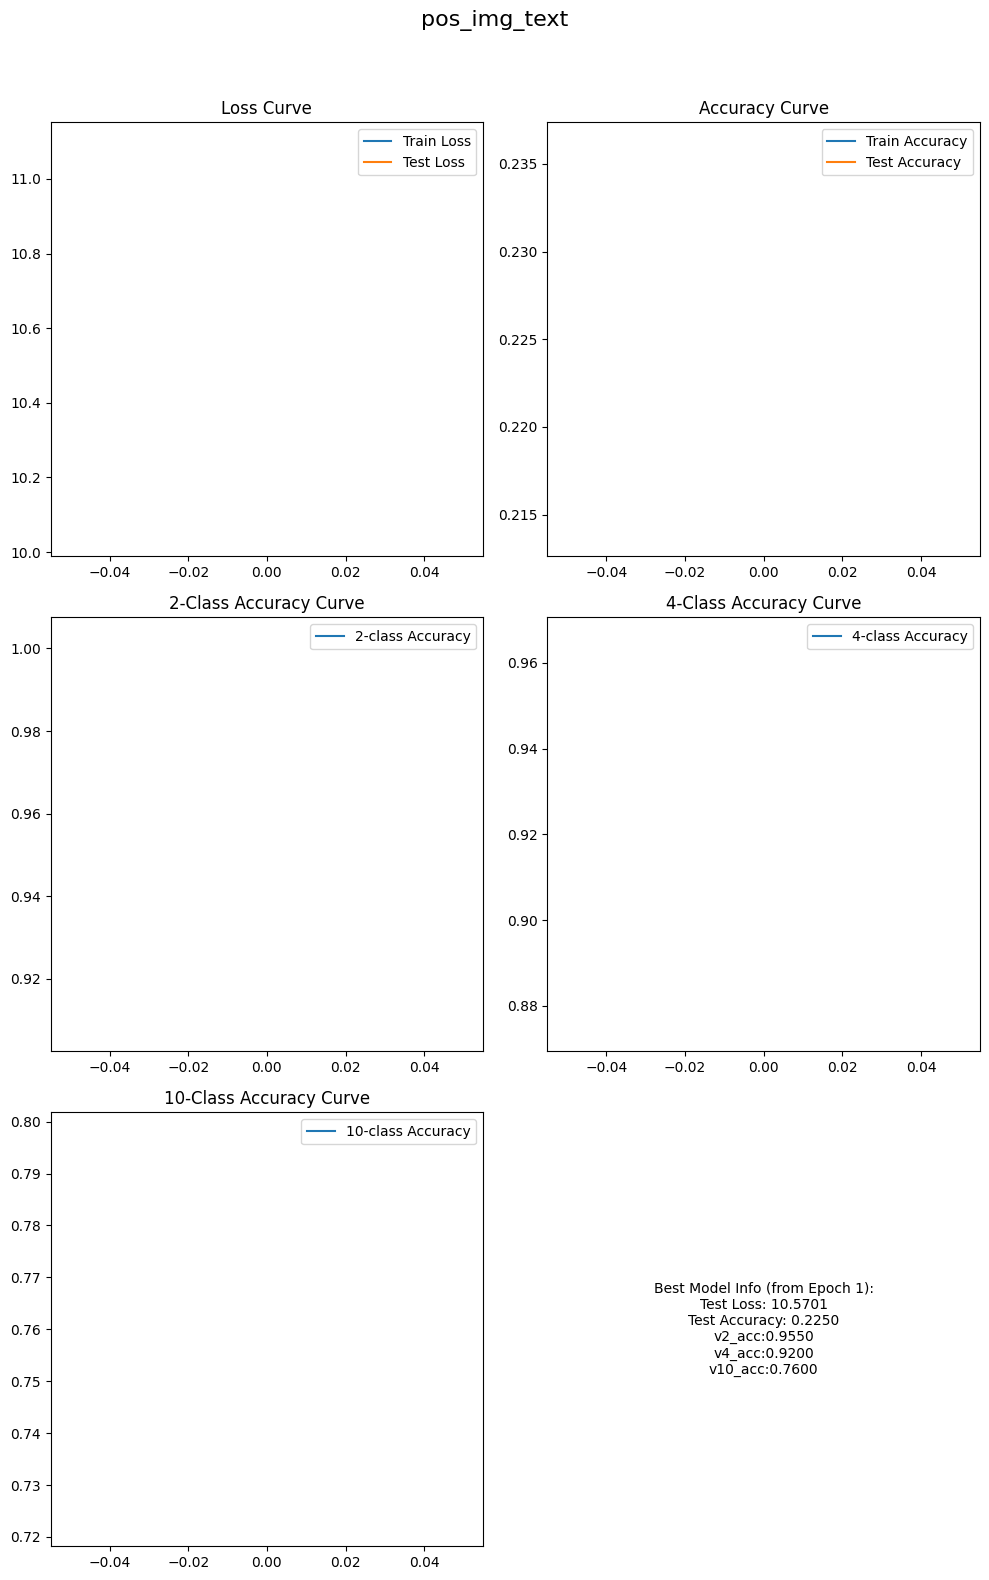

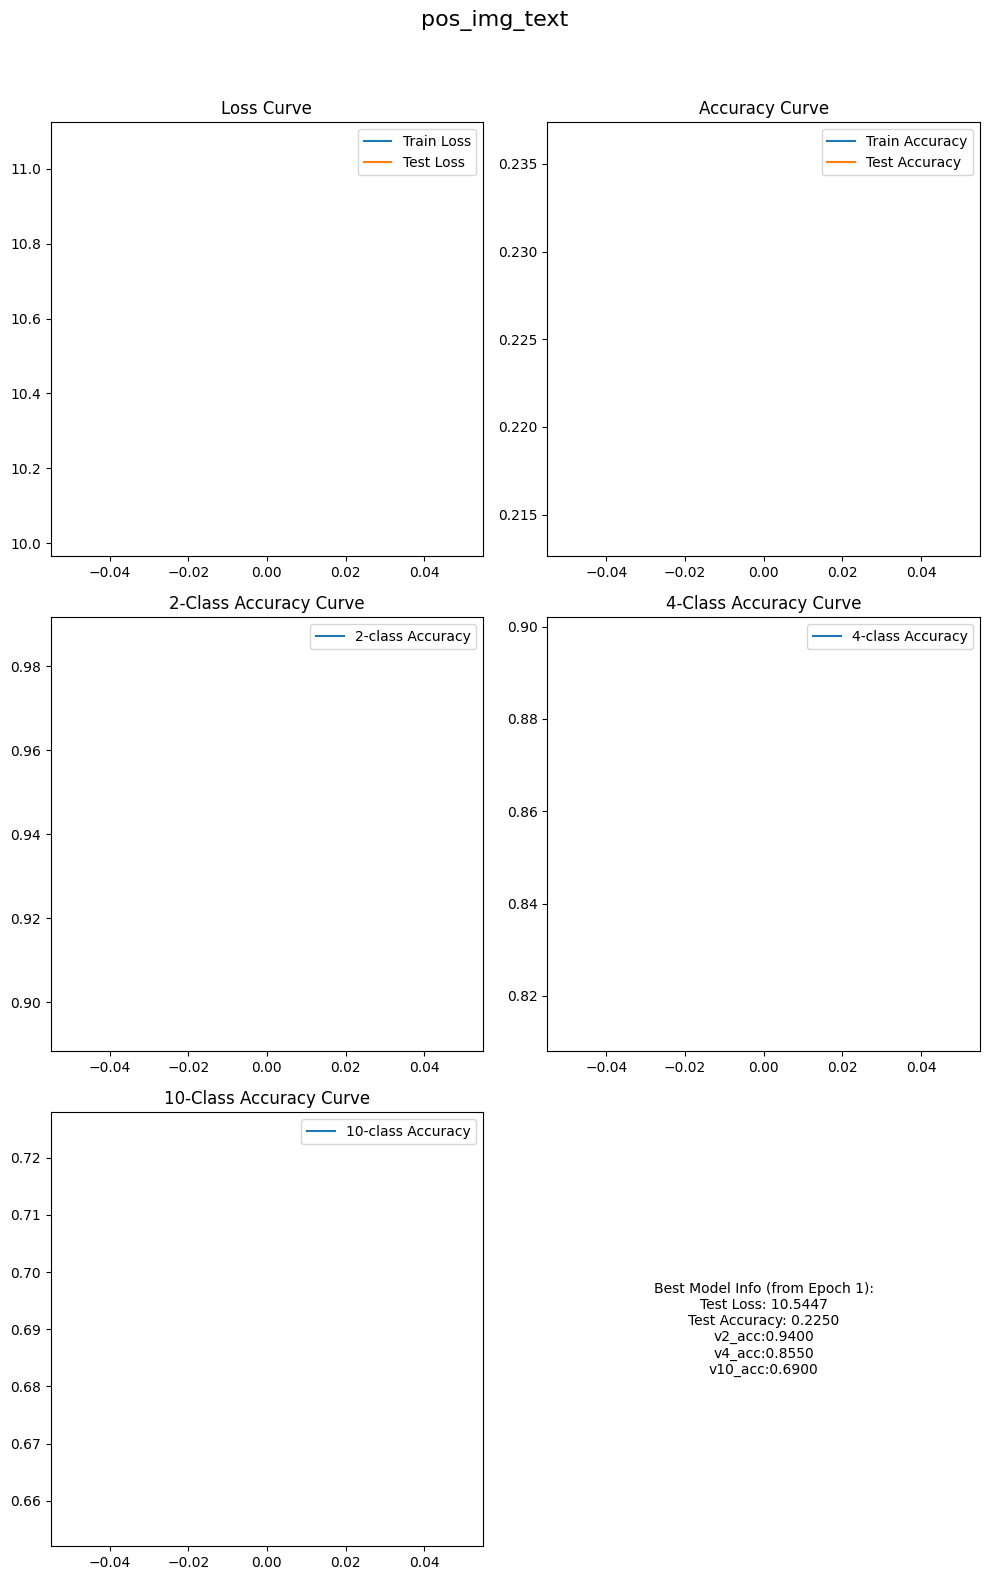

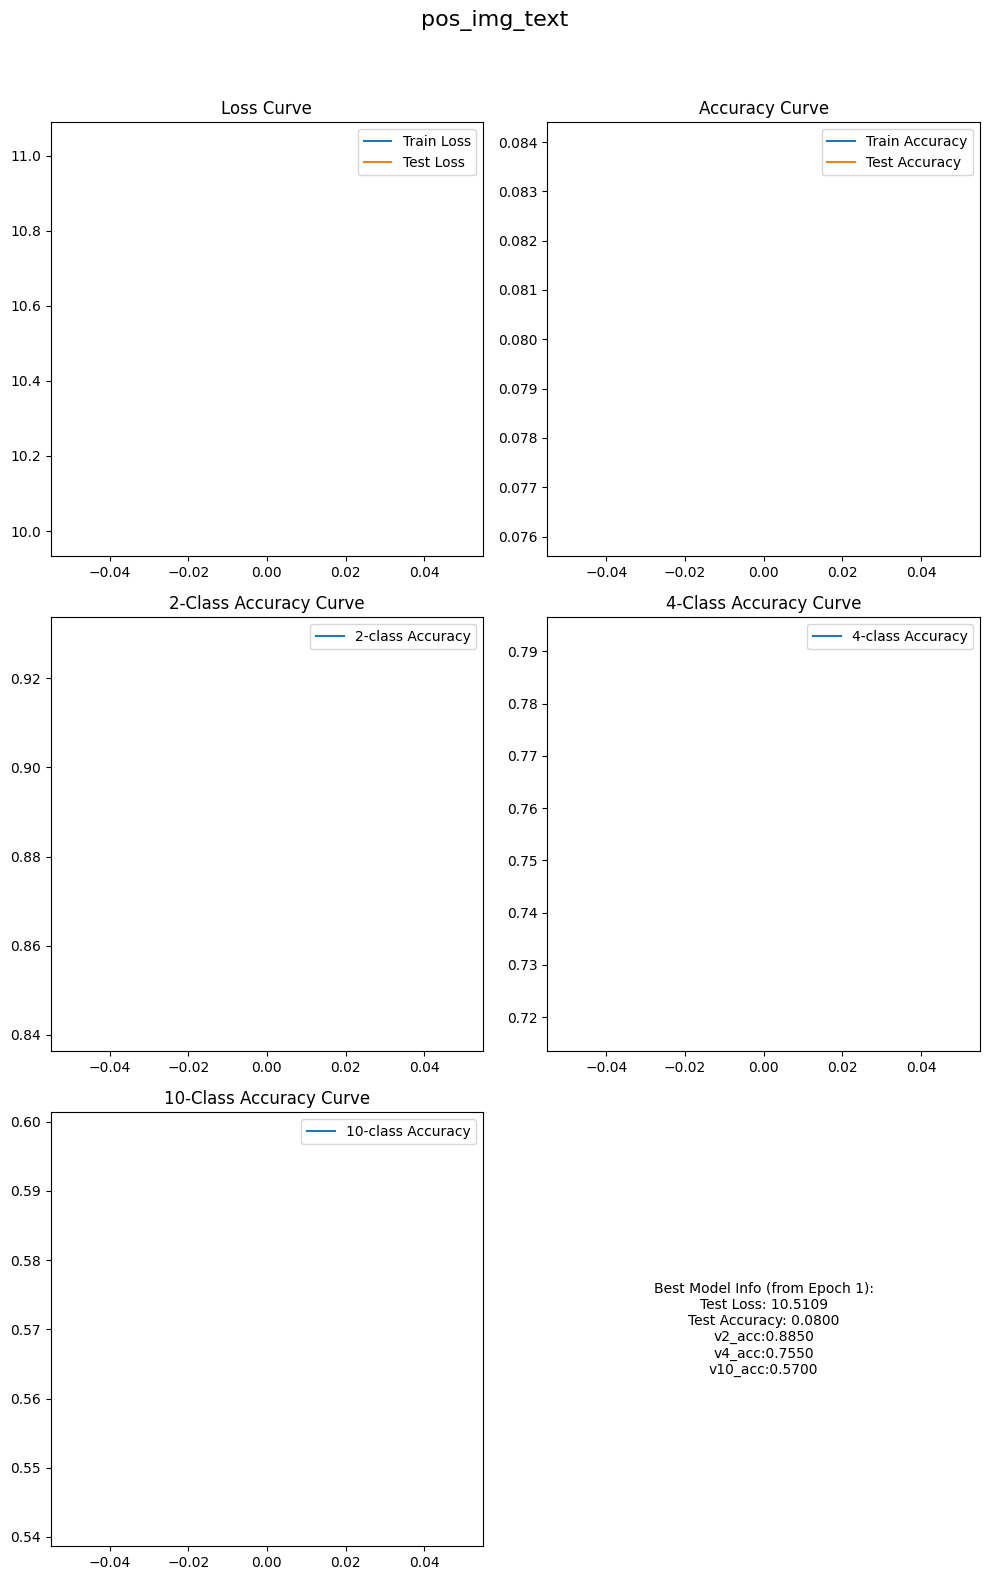

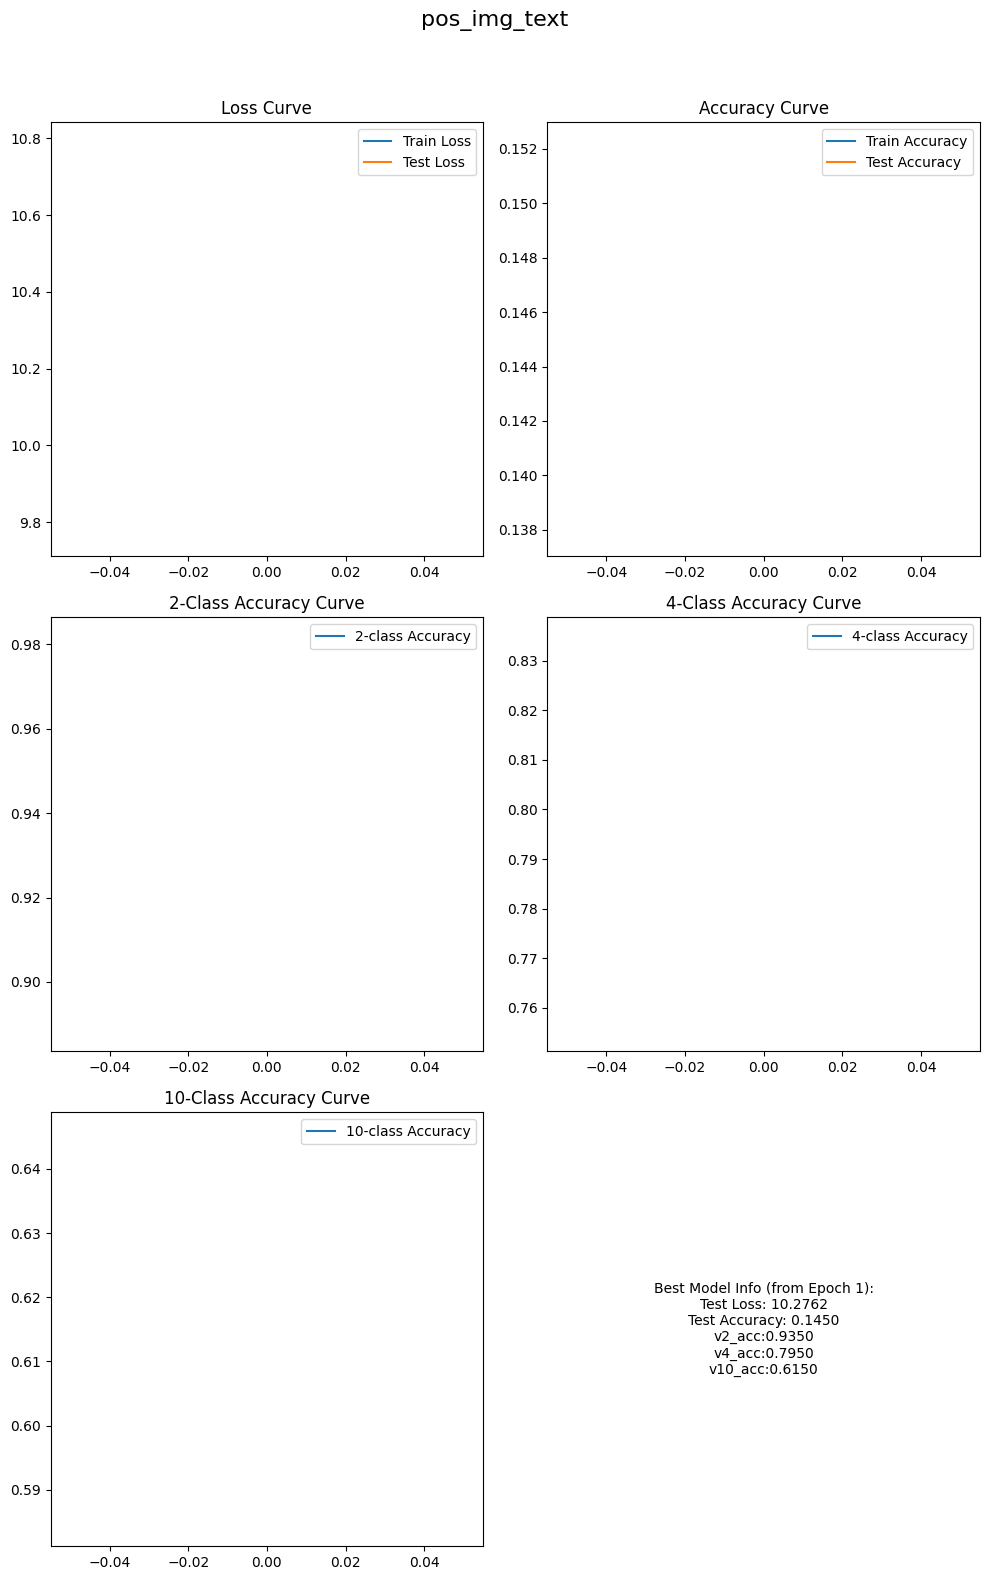

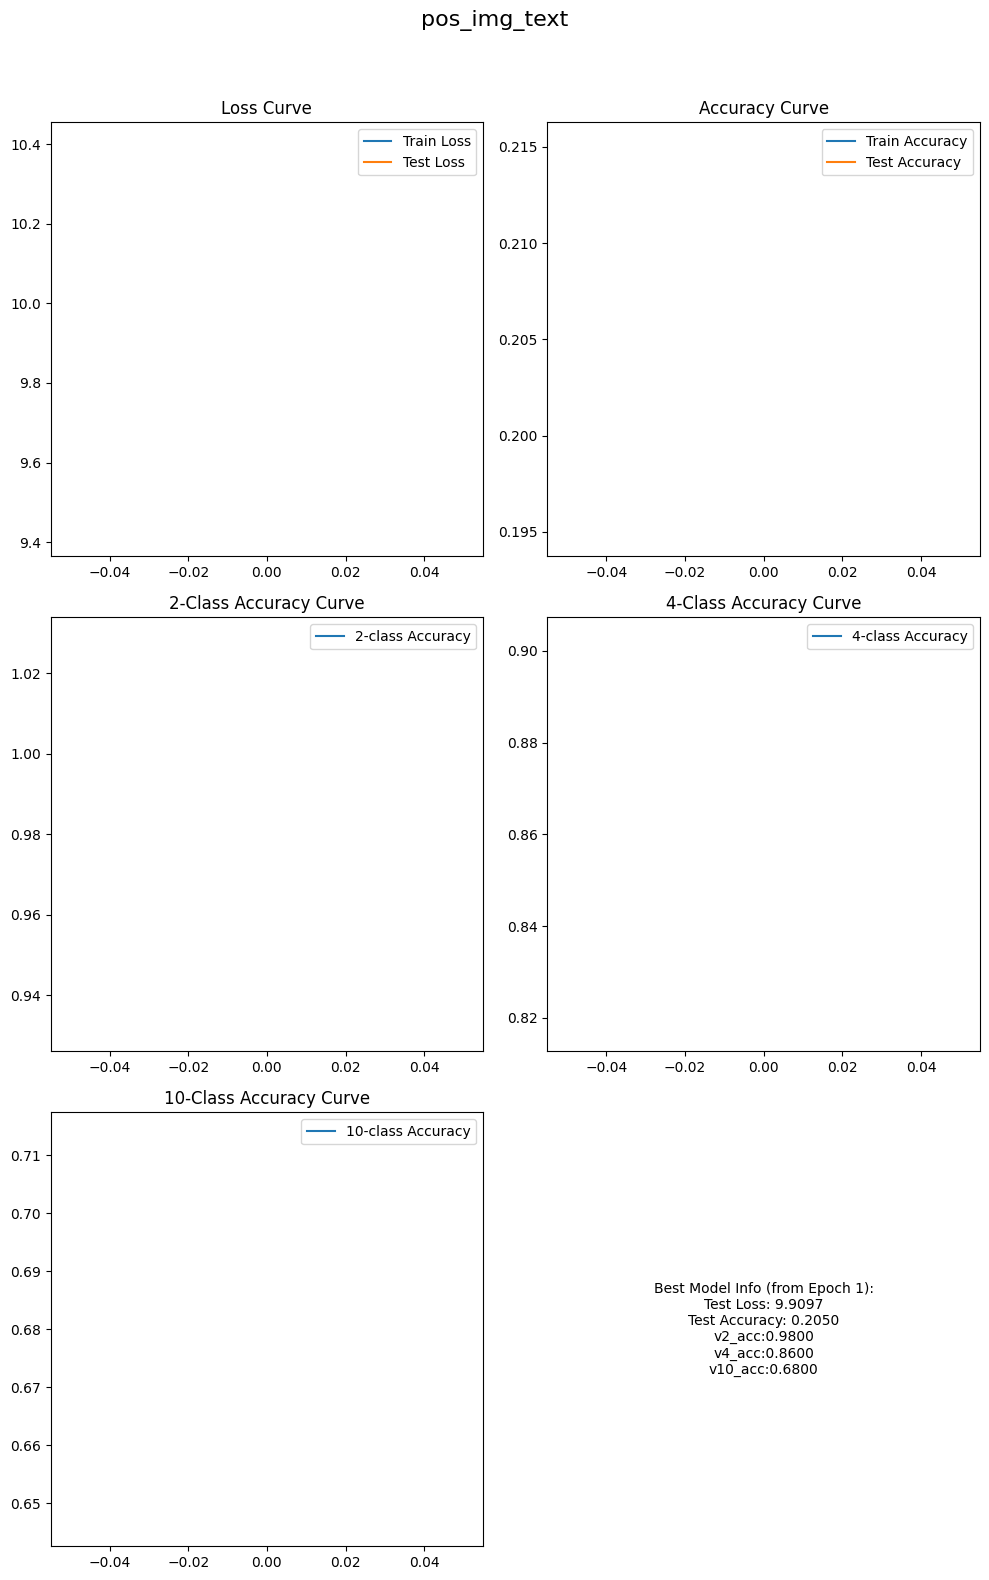

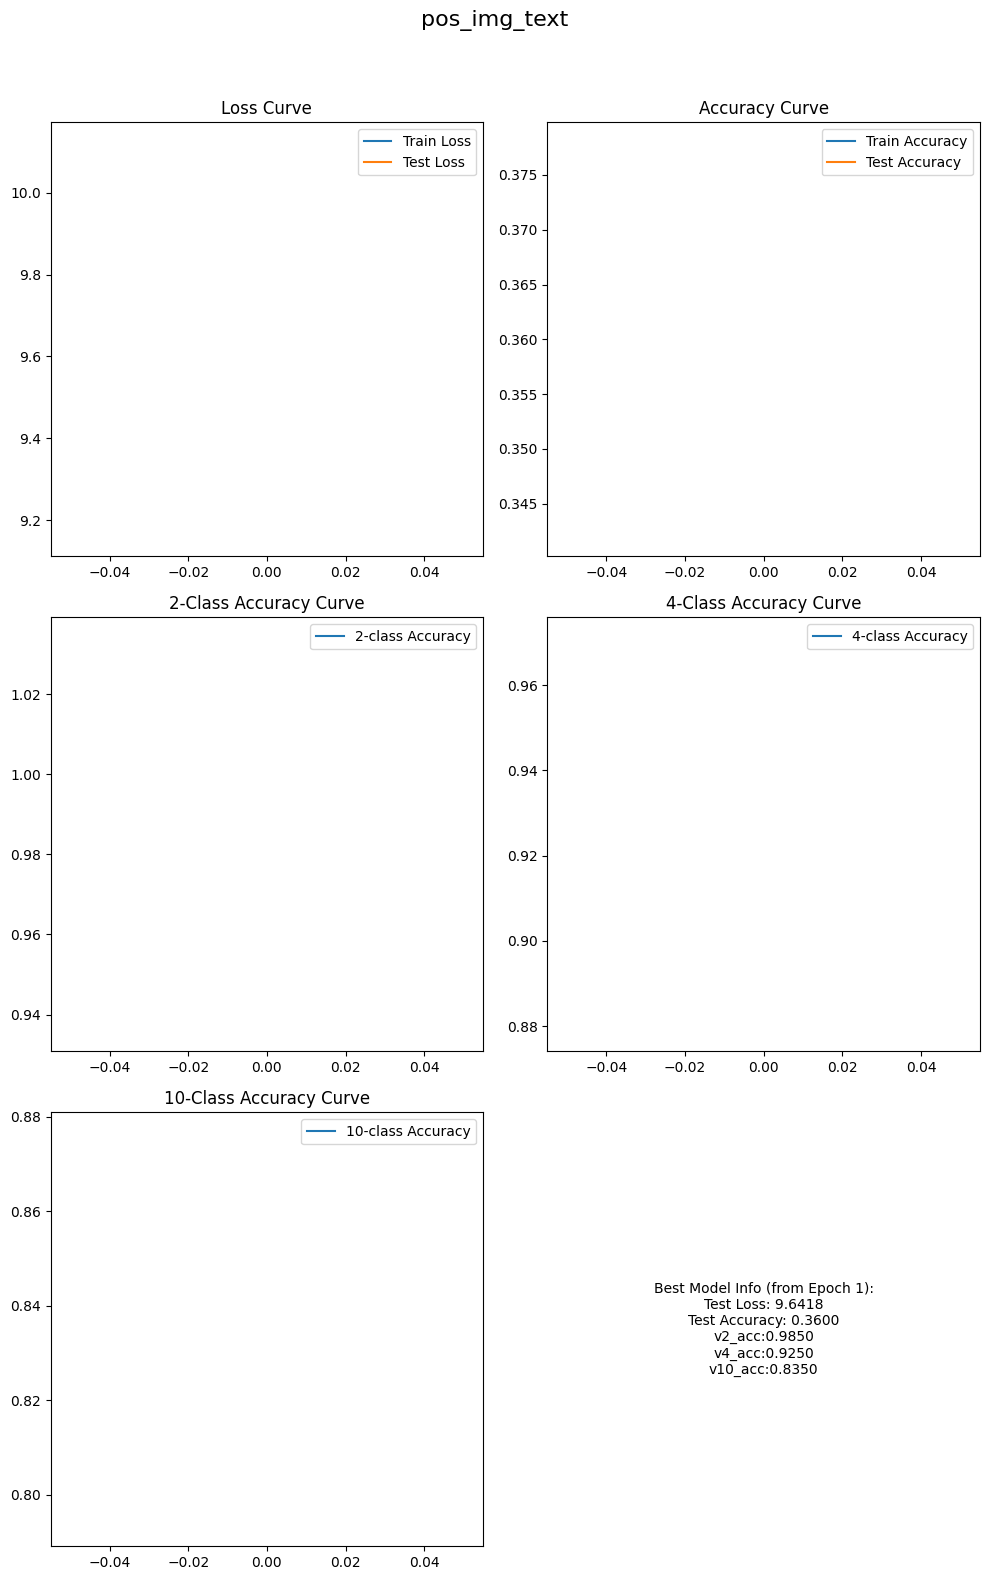

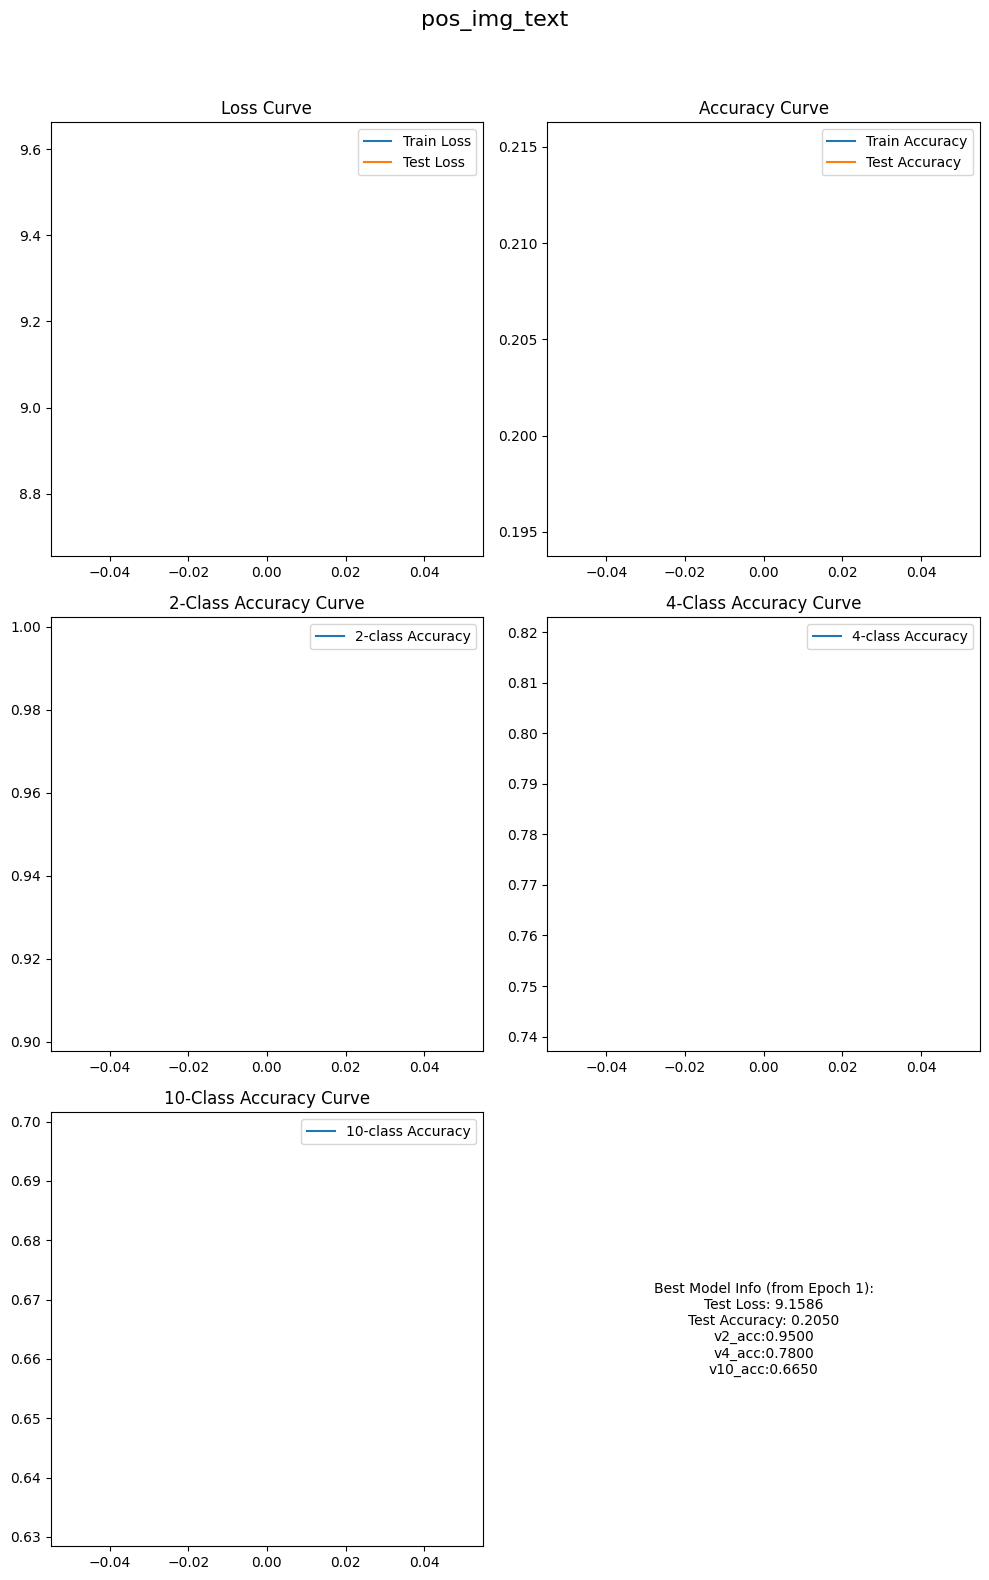

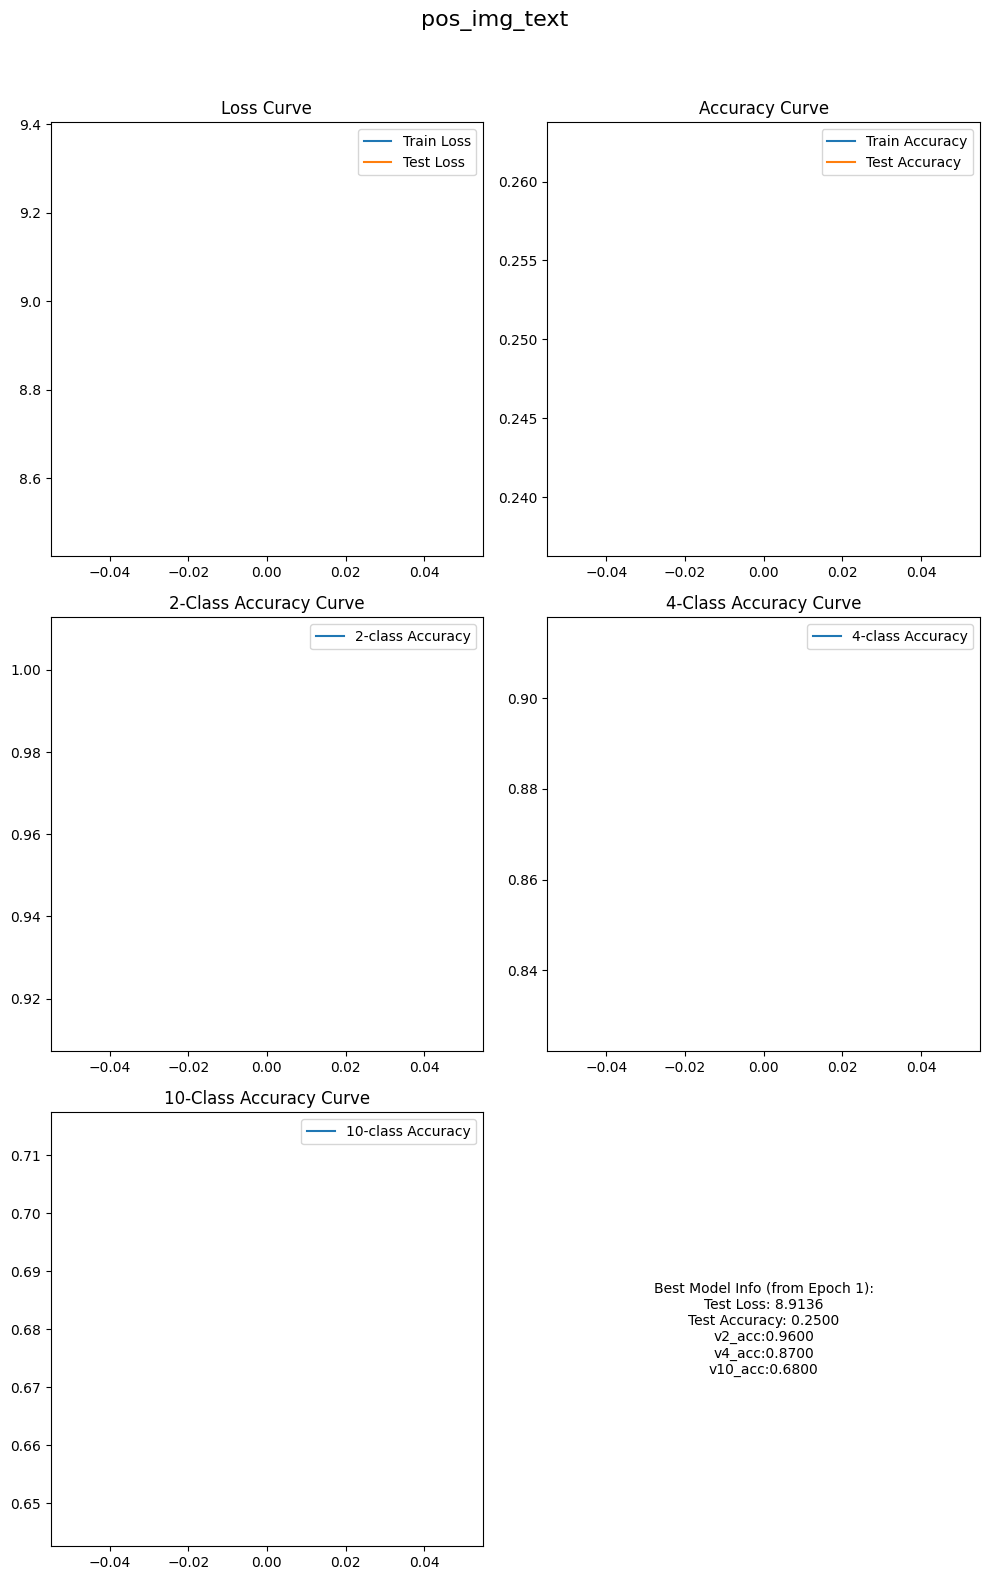

In [1]:
import os

import torch
import torch.optim as optim
from torch.nn import CrossEntropyLoss
from torch.nn import functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader

os.environ["WANDB_API_KEY"] = "KEY"
os.environ["WANDB_MODE"] = 'offline'
from itertools import combinations

import clip
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torchvision.transforms as transforms
import tqdm
from eegdatasets_leaveone_measure import EEGDataset
from eegencoder import eeg_encoder
from einops.layers.torch import Rearrange, Reduce
from lavis.models.clip_models.loss import ClipLoss
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader, Dataset
import random
from utils import wandb_logger
from braindecode.models import EEGNetv4, ATCNet, EEGConformer, EEGITNet, ShallowFBCSPNet
import csv
from torch import Tensor
import itertools
import math
import datetime



class PatchEmbedding(nn.Module):
    def __init__(self, emb_size=40):
        super().__init__()
        # revised from shallownet
        self.tsconv = nn.Sequential(
            nn.Conv2d(1, 40, (1, 25), (1, 1)),
            nn.AvgPool2d((1, 51), (1, 5)),
            nn.BatchNorm2d(40),
            nn.ELU(),
            nn.Conv2d(40, 40, (63, 1), (1, 1)),
            nn.BatchNorm2d(40),
            nn.ELU(),
            nn.Dropout(0.5),
        )

        self.projection = nn.Sequential(
            nn.Conv2d(40, emb_size, (1, 1), stride=(1, 1)),  
            Rearrange('b e (h) (w) -> b (h w) e'),
        )

    def forward(self, x: Tensor) -> Tensor:
        # b, _, _, _ = x.shape
        x = x.unsqueeze(1)     
        # print("x", x.shape)   
        x = self.tsconv(x)
        # print("tsconv", x.shape)   
        x = self.projection(x)
        # print("projection", x.shape)  
        return x


class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x


class FlattenHead(nn.Sequential):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        x = x.contiguous().view(x.size(0), -1)
        return x


class Enc_eeg(nn.Sequential):
    def __init__(self, emb_size=40, **kwargs):
        super().__init__(
            PatchEmbedding(emb_size),
            FlattenHead()
        )

        
class Proj_eeg(nn.Sequential):
    def __init__(self, embedding_dim=1440, proj_dim=1024, drop_proj=0.5):
        super().__init__(
            nn.Linear(embedding_dim, proj_dim),
            ResidualAdd(nn.Sequential(
                nn.GELU(),
                nn.Linear(proj_dim, proj_dim),
                nn.Dropout(drop_proj),
            )),
            nn.LayerNorm(proj_dim),
        )


class Proj_img(nn.Sequential):
    def __init__(self, embedding_dim=1024, proj_dim=1024, drop_proj=0.3):
        super().__init__(
            nn.Linear(embedding_dim, proj_dim),
            ResidualAdd(nn.Sequential(
                nn.GELU(),
                nn.Linear(proj_dim, proj_dim),
                nn.Dropout(drop_proj),
            )),
            nn.LayerNorm(proj_dim),
        )
    def forward(self, x):
        return x 

class NICE(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc_eeg = Enc_eeg()
        self.proj_eeg = Proj_eeg()
        self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))
        self.loss_func = ClipLoss()        
    def forward(self, data):
        eeg_embedding = self.enc_eeg(data)
        out = self.proj_eeg(eeg_embedding)

        return out  
      

def train_model(eegmodel, imgmodel, dataloader, optimizer, device, text_features_all, img_features_all):
    eegmodel.train()
    text_features_all = text_features_all.to(device).float() # (n_cls, d)
    img_features_all = (img_features_all[::10]).to(device).float()
    total_loss = 0
    correct = 0
    total = 0
    alpha=0.9
    features_list = []  # List to store features
    save_features= True
    ridge_lambda = 0.1
    mse_loss_fn = nn.MSELoss()
    for batch_idx, (eeg_data, labels, text, text_features, img, img_features) in enumerate(dataloader):
        eeg_data = eeg_data.to(device)
        text_features = text_features.to(device).float()
        img_features = img_features.to(device).float()
        labels = labels.to(device)
        
        optimizer.zero_grad()
        eeg_features = eegmodel(eeg_data).float()
        # img_features_outputs = regression(eeg_features).float()
        features_list.append(eeg_features)
        logit_scale = eegmodel.logit_scale
        img_loss = eegmodel.loss_func(eeg_features, img_features, logit_scale)
        text_loss = eegmodel.loss_func(eeg_features, text_features, logit_scale)
        contrastive_loss = img_loss
        # print("text_loss", text_loss)
        # print("img_loss", img_loss)
        
        regress_loss =  mse_loss_fn(eeg_features, img_features)
        # l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
        # loss = (regress_loss + ridge_lambda * l2_norm)       
        loss = (alpha * regress_loss *10 + (1 - alpha) * contrastive_loss*10)
        loss.backward()
        
        optimizer.step()
        total_loss += loss.item()
        
        # logits = logit_scale * eeg_features @ text_features_all.T # (n_batch, n_cls)
        # 计算对应的 logits
        logits_img = logit_scale * eeg_features @ img_features_all.T
        # logits_text = logit_scale * eeg_features @ text_features_all.T
        # logits_single = (logits_text + logits_img) / 2.0        
        # logits_text = logit_scale * eeg_features @ text_features_all.T
        logits_single = logits_img
        predicted = torch.argmax(logits_single, dim=1) # (n_batch, ) \in {0, 1, ..., n_cls-1}

        batch_size = predicted.shape[0]
        total += batch_size
        correct += (predicted == labels).sum().item()

    average_loss = total_loss / (batch_idx+1)
    accuracy = correct / total
    return average_loss, accuracy

def evaluate_model(eegmodel, imgmodel, dataloader, device, text_features_all, img_features_all, generated_features_all, k):
    eegmodel.eval()
    text_features_all = text_features_all.to(device).float()
    img_features_all = img_features_all.to(device).float()
    total_loss = 0
    correct = 0
    total = 0
    alpha =0.9
    top5_correct = 0
    top5_correct_count = 0
    # 获取所有独特的类别
    all_labels = set(range(text_features_all.size(0)))
    top5_acc = 0
    mse_loss_fn = nn.MSELoss()
    ridge_lambda = 0.1
    with torch.no_grad():
        for batch_idx, (eeg_data, labels, text, text_features, img, img_features) in enumerate(dataloader):
            eeg_data = eeg_data.to(device)    
            
            text_features = text_features.to(device).float()
            labels = labels.to(device)
            img_features = img_features.to(device).float()
            eeg_features = eegmodel(eeg_data).float()
            logit_scale = eegmodel.logit_scale                    
            regress_loss =  mse_loss_fn(eeg_features, img_features)
            # print("eeg_features", eeg_features.shape)
            # print(torch.std(eeg_features, dim=-1))
            # print(torch.std(img_features, dim=-1))
            # l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
            # loss = (regress_loss + ridge_lambda * l2_norm)       
            img_loss = eegmodel.loss_func(eeg_features, img_features, logit_scale)
            text_loss = eegmodel.loss_func(eeg_features, text_features, logit_scale)
            contrastive_loss = img_loss
            # loss = img_loss + text_loss

            regress_loss =  mse_loss_fn(eeg_features, img_features)
            # print("text_loss", text_loss)
            # print("img_loss", img_loss)
            # print("regress_loss", regress_loss)            
            # l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
            # loss = (regress_loss + ridge_lambda * l2_norm)       
            loss = alpha * regress_loss *10 + (1 - alpha) * contrastive_loss*10
            # print("loss", loss)
            total_loss += loss.item()
            
            for idx, label in enumerate(labels):
                # 先从除了正确类别之外的类别中选择 k-1 个
                possible_classes = list(all_labels - {label.item()})
                selected_classes = random.sample(possible_classes, k-1) + [label.item()]
                selected_img_features = generated_features_all[::10][selected_classes]
                # selected_img_features = img_features_all[selected_classes]
                selected_text_features = text_features_all[selected_classes]
                
                if k==200:
                    # 计算对应的 logits
                    logits_img = logit_scale * eeg_features[idx] @ selected_img_features.T
                    logits_single = logits_img
                    # print("logits_single", logits_single.shape)
                    # 获取预测的类别
                    # predicted_label = selected_classes[torch.argmax(logits_single).item()]
                    predicted_label = selected_classes[torch.argmax(logits_single).item()] # (n_batch, ) \in {0, 1, ..., n_cls-1}
                    if predicted_label == label.item():
                        # print("predicted_label", predicted_label)
                        correct += 1
                    
                    # logits_single 是模型的输出，假设其形状为 (n_batch, n_classes)
                    # label 是真实的标签，形状为 (n_batch,)
                    # 获取top-5预测的索引
                    # print("logits_single", logits_single)
                    _, top5_indices = torch.topk(logits_single, 5, largest =True)
                                                           
                    # 检查真实标签是否在top-5预测中
                    if label.item() in [selected_classes[i] for i in top5_indices.tolist()]:                
                        top5_correct_count+=1                                
                    total += 1
                elif k==2 or k==4 or k==10:
                    # 计算对应的 logits
                    logits_img = logit_scale * eeg_features[idx] @ selected_img_features.T
                    # logits_text = logit_scale * eeg_features[idx] @ selected_text_features.T
                    # logits_single = (logits_text + logits_img) / 2.0
                    logits_single = logits_img
                    # print("logits_single", logits_single.shape)
                    # 获取预测的类别
                    # predicted_label = selected_classes[torch.argmax(logits_single).item()]
                    predicted_label = selected_classes[torch.argmax(logits_single).item()] # (n_batch, ) \in {0, 1, ..., n_cls-1}
                    if predicted_label == label.item():
                        correct += 1
                    total += 1
                else:
                    print("Error.")
                    
    # print("total_loss", total_loss)
    # print("batch_idx+1", batch_idx+1)                
    average_loss = total_loss / (batch_idx+1)
    accuracy = correct / total
    top5_acc = top5_correct_count / total
    return average_loss, accuracy, top5_acc

def main_train_loop(sub, eeg_model, img_model, train_dataloader, test_dataloader, optimizer, device, 
                    text_features_train_all, text_features_test_all, img_features_train_all, img_features_test_all, generated_features_all, config, logger=None):
    logger = wandb_logger(config) if logger else None
    logger.watch(eeg_model,logger) 
    logger.watch(img_model,logger) 
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []
    v2_accs = []
    v4_accs = []
    v10_accs = []

    best_accuracy = 0.0
    best_model_weights = None
    best_epoch_info = {}
    results = []  # List to store results for each epoch
  
    for epoch in range(config['epochs']):
        # 训练模型
        # train_loss, train_accuracy = train_model(eeg_model, img_model, train_dataloader, optimizer, device, text_features_train_all, img_features_train_all)
        # if (epoch +1) % 5 == 0:               
        #     if config['insubject']==True:       
        #         os.makedirs(f"./models/contrast/{config['encoder_type']}/{sub}/{current_time}", exist_ok=True)             
        #         file_path = f"./models/contrast/{config['encoder_type']}/{sub}/{current_time}/{epoch+1}.pth"
        #         torch.save(eeg_model.state_dict(), file_path)            
        #     else:                
        #         os.makedirs(f"./models/contrast/across/{config['encoder_type']}/{current_time}", exist_ok=True)             
        #         file_path = f"./models/contrast/across/{config['encoder_type']}/{current_time}/{epoch+1}.pth"
        #         torch.save(eeg_model.state_dict(), file_path)
        #     print(f"model saved in {file_path}!")
        # eeg_model.load_state_dict(torch.load(f"/home/ldy/Workspace/BrainAligning_retrieval/models/contrast/NICE/{sub}/40.pth", map_location=device))
        import os
        import glob
        import torch
        from datetime import datetime

        # 假设 device 是您已经定义好的
        # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


        # 构建路径
        sub_path = f"/home/ldy/Workspace/BrainAligning_retrieval/models/contrast/NICE/{sub}"

        # 获取所有时间命名的文件夹
        time_folders = glob.glob(os.path.join(sub_path, "*/"))
        if not time_folders:
            raise ValueError(f"No time-named folders found in {sub_path}")

        # 定义一个解析时间的函数
        def parse_folder_time(folder_name):
            # 假设文件夹名字是时间格式 "月-日_时-分"
            try:
                return datetime.strptime(os.path.basename(os.path.normpath(folder_name)), "%m-%d_%H-%M")
            except ValueError:
                return None

        # 解析所有文件夹的时间，并过滤掉无法解析的
        parsed_folders = [(folder, parse_folder_time(folder)) for folder in time_folders]
        parsed_folders = [pf for pf in parsed_folders if pf[1] is not None]

        # 如果没有可解析的文件夹，抛出异常
        if not parsed_folders:
            raise ValueError(f"No folders with valid time format found in {sub_path}")

        # 根据时间进行排序，选择最新的一个
        latest_folder = max(parsed_folders, key=lambda x: x[1])[0]

        # 构建最终的文件路径
        final_path = os.path.join(latest_folder, "40.pth")
        if not os.path.exists(final_path):
            raise FileNotFoundError(f"File {final_path} does not exist")

        # 加载模型状态
        eeg_model.load_state_dict(torch.load(final_path, map_location=device))

        eeg_model = eeg_model.to(device)
        generated_features_all = generated_features_all.to(device)
        # eegmodel.eval()
        test_loss, test_accuracy, top5_acc = evaluate_model(eeg_model, img_model, test_dataloader, device, text_features_test_all, img_features_test_all, generated_features_all, k=200)
        _, v2_acc, _ = evaluate_model(eeg_model, img_model, test_dataloader, device, text_features_test_all, img_features_test_all, generated_features_all, k = 2)
        _, v4_acc, _ = evaluate_model(eeg_model, img_model, test_dataloader, device, text_features_test_all, img_features_test_all, generated_features_all, k = 4)
        _, v10_acc, _ = evaluate_model(eeg_model, img_model, test_dataloader, device, text_features_test_all, img_features_test_all, generated_features_all, k = 10)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        v2_accs.append(v2_acc)
        v4_accs.append(v4_acc)
        v10_accs.append(v10_acc)
        # Append results for this epoch
        epoch_results = {
        "epoch": epoch + 1,
        # "train_loss": train_loss,
        # "train_accuracy": train_accuracy,
        "test_loss": test_loss,
        "test_accuracy": test_accuracy,
        "v2_acc": v2_acc,
        "v4_acc": v4_acc,
        "v10_acc": v10_acc,
        "top5_acc":top5_acc
        }
        results.append(epoch_results)
        # 如果当前epoch的测试正确率是最好的，保存模型和相关信息
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            # best_model_weights = model.state_dict().copy()
            
            best_epoch_info = {
                "epoch": epoch + 1,
                # "train_loss": train_loss,
                # "train_accuracy": train_accuracy,
                "test_loss": test_loss,
                "test_accuracy": test_accuracy,
                "v2_acc":v2_acc,
                "v4_acc":v4_acc,
                "v10_acc":v10_acc
            }
        logger.log({
            # "Train Loss": train_loss,
            # "Train Accuracy": train_accuracy,
            "Test Loss": test_loss,
            "Test Accuracy": test_accuracy,
            "v2 Accuracy": v2_acc,
            "v4 Accuracy": v4_acc,
            "v10 Accuracy": v10_acc,
            "Epoch": epoch
        })

        print(f"Epoch {epoch + 1}/{config['epochs']} - Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Top5 Accuracy: {top5_acc:.4f}")
        print(f"Epoch {epoch + 1}/{config['epochs']} - v2 Accuracy:{v2_acc} - v4 Accuracy:{v4_acc} - v10 Accuracy:{v10_acc}")
  
    # # 加载最佳模型权重
    # model.load_state_dict(best_model_weights)

    # # # 保存最佳模型
    # torch.save(model.state_dict(), '{train_pos_img_text}.pth')

    # 创建5个子图
    fig, axs = plt.subplots(3, 2, figsize=(10, 15))

    # 损失图
    axs[0, 0].plot(train_losses, label='Train Loss')
    axs[0, 0].plot(test_losses, label='Test Loss')
    axs[0, 0].legend()
    axs[0, 0].set_title("Loss Curve")

    # 总体正确率图
    axs[0, 1].plot(train_accuracies, label='Train Accuracy')
    axs[0, 1].plot(test_accuracies, label='Test Accuracy')
    axs[0, 1].legend()
    axs[0, 1].set_title("Accuracy Curve")

    # 以下是你新添加的三个图，这里假设你已经计算了对应的正确率
    # 2分类正确率图
    axs[1, 0].plot(v2_accs, label='2-class Accuracy')
    axs[1, 0].legend()
    axs[1, 0].set_title("2-Class Accuracy Curve")

    # 4分类正确率图
    axs[1, 1].plot(v4_accs, label='4-class Accuracy')
    axs[1, 1].legend()
    axs[1, 1].set_title("4-Class Accuracy Curve")

    # 10分类正确率图
    axs[2, 0].plot(v10_accs, label='10-class Accuracy')
    axs[2, 0].legend()
    axs[2, 0].set_title("10-Class Accuracy Curve")

    # 构造你要注释的字符串信息
    info_text = (f"Best Model Info (from Epoch {best_epoch_info['epoch']}):\n"
                # f"Train Loss: {best_epoch_info['train_loss']:.4f}\n"
                # f"Train Accuracy: {best_epoch_info['train_accuracy']:.4f}\n"
                f"Test Loss: {best_epoch_info['test_loss']:.4f}\n"
                f"Test Accuracy: {best_epoch_info['test_accuracy']:.4f}\n"
                f"v2_acc:{best_epoch_info['v2_acc']:.4f}\n"
                f"v4_acc:{best_epoch_info['v4_acc']:.4f}\n"
                f"v10_acc:{best_epoch_info['v10_acc']:.4f}")

    axs[2, 1].axis('off')  
    axs[2, 1].text(0.5, 0.5, info_text, fontsize=10, ha='center', va='center', transform=axs[2, 1].transAxes)

    plt.tight_layout()

    # 添加大标题
    plt.suptitle('pos_img_text', fontsize=16, y=1.05)
    plt.savefig('pos_img_text')
    logger.finish()
    return results


def main():
    Encoder_list = ['EEGNetv4_Encoder', 'ATCNet_Encoder', 'EEGConformer_Encoder', 'EEGITNet_Encoder', 'ShallowFBCSPNet_Encoder'] 
    config = {
    "data_path": "/home/ldy/Workspace/THINGS/Preprocessed_data_250Hz",
    "project": "train_pos_img_text_rep",
    "entity": "sustech_rethinkingbci",
    "name": "lr=3e-4_img_pos_pro_eeg",
    "lr": 3e-4,
    "epochs": 1,
    "batch_size": 1024,
    "logger": True,
    "insubject": True,
    "encoder_type": 'NICE',
    "img_encoder": 'Proj_img'
    }

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    subjects = ['sub-01', 'sub-02', 'sub-03', 'sub-04', 'sub-05', 'sub-06', 'sub-07', 'sub-08', 'sub-09', 'sub-10']
    
    for sub in subjects:                    
        # Instantiate a new model for each subject
        eeg_model = globals()[config['encoder_type']]()
        img_model = globals()[config['img_encoder']]()
        eeg_model.to(device)
        img_model.to(device)

        # Reinitialize the optimizer for the new models
        optimizer = torch.optim.AdamW(itertools.chain(eeg_model.parameters(), img_model.parameters()), lr=config['lr'])

        if config['insubject']:
            train_dataset = None
            test_dataset = EEGDataset(config['data_path'], subjects=[sub], train=False)
        else:
            train_dataset = EEGDataset(config['data_path'], exclude_subject=sub, train=True)
            test_dataset = EEGDataset(config['data_path'], exclude_subject=sub, train=False)

        train_loader = None if config['insubject'] else DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=0, drop_last=True)
        test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=0, drop_last=True)

        text_features_train_all = None if config['insubject'] else train_dataset.text_features
        img_features_train_all = None if config['insubject'] else train_dataset.img_features
        text_features_test_all = test_dataset.text_features
        img_features_test_all = test_dataset.img_features        
        generated_features_all = test_dataset.generated_features

        results = main_train_loop(sub, eeg_model, img_model, train_loader, test_loader, optimizer, device, 
                                  text_features_train_all, text_features_test_all, 
                                  img_features_train_all, img_features_test_all, 
                                  generated_features_all, config, logger=config['logger'])

        # Save results to a CSV file
        results_file = f'./generation_metric_outputs/{config["encoder_type"]}_{"in" if config["insubject"] else "cross_exclude_"}{sub}.csv'
        with open(results_file, 'w', newline='') as file:
            writer = csv.DictWriter(file, fieldnames=results[0].keys())
            writer.writeheader()
            writer.writerows(results)
        print(f'Results saved to {results_file}')
            
if __name__ == '__main__':
    main()